# GDrive Setup

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')


In [2]:
# %cd /content/drive/MyDrive/Radboud/Master/Semester2/SPML/Tutorials/Tutorial8_Federated_Learning
# !ls

# Imports

In [3]:
# Colab already has this installed, uncomment if you are running locally
!pip install ipywidgets
!pip3 install pytorch-lightning

In [ ]:
from src.Utils import *
from src.DataLoader import *
from src.ResNet18Light import *
from src.ModelUtils import *
from src.TrainingUtils import *
from src.ModelStateDictNames import *
from src.PoisoningUtils import *

# Torch Imports
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.nn.functional import cross_entropy

# Plotting
import matplotlib.ticker as mtick
from matplotlib import pyplot as plt
from PIL import Image

# Computation & Math
import math
import numpy as np
import random

# Utilities
import datetime
from collections import defaultdict
from pprint import pprint
import time
from tqdm import tqdm

# for image loading
from PIL import Image, ImageOps

# Fixing Seed
# Colab already has this installed

from pytorch_lightning import seed_everything
seed_everything(42) # reproducibility

Seed set to 42


42

# Settings



Below we specified some settings you will need for this tutorial:
- `TOTAL_CLIENT_NUMBER`: The number of users that participate in the federated learning process. Each will train a model and upload results to a central point where it is aggregated.
- `POISONED_MODEL_RATE`: This percentage specifies how many of the clients/users will be malicious and thus will insert a backdoor in the training data.
- `NUMBER_OF_ADVERSARIES`: The total number of clients/users that is malicious and will insert a backdoor in the training data.
- `NUMBER_OF_BENIGN_CLIENTS`: The total number of clients/users that is benign and will perform clean training.
- `IID_RATE`: The percentage of independent and identically distrubuted data.
- `SAMPLES_PER_CLIENT`: The number of data samples each client will handle.
- `BATCH_SIZE`: The batch size used during training.
- `LOCAL_EPOCHS_FOR_BENIGN_CLIENTS`: The number of epochs for the local training by each client.

In [51]:
class Q1_Config:

    # Define parameters
    TOTAL_CLIENT_NUMBER = 5
    NUMBER_OF_ADVERSARIES = 2
    NUMBER_OF_BENIGN_CLIENTS = TOTAL_CLIENT_NUMBER - NUMBER_OF_ADVERSARIES
    IID_RATE = 0.9 # Do we need to do IID? Yes keep to make data distributions more realistic
    POISONING_RATE = 0.5
    GLOBAL_AGGREGATION_ROUNDS = 5
    LOCAL_EPOCHS = 2
    BACKDOOR_TARGET_CLASS = 3  # Cat label
    SELECTED_CLIENTS_PER_ROUND = 5
    AGGREGATION_METHOD = 'FedAvg'

    # Do we need these parameters? Keep until told otherwise.
    SAMPLES_PER_CLIENT = 384
    BATCH_SIZE = 64


print(Q1_Config.TOTAL_CLIENT_NUMBER)

5


In [53]:
#Send computation to a gpu if exists
USE_GPU = True if torch.cuda.is_available() else False
COMPUTATION_DEVICE = torch.device(f"cuda:{0}" if USE_GPU else "cpu")
print(f"Computation Device = {COMPUTATION_DEVICE}")

Computation Device = cpu


# Load data and create dataset



Again, you will work with the CIFAR-10 dataset. The CIFAR-10 dataset consists of 60k images in total, divided into 50k images for training and 10k images for testing. Training and test data are disjoint for measuring the generalization ability of the model.

You will divide the training data into 30 local datasets of the individual clients. To make the data distribution more realistic (clients with different data distribution), you randomly distibute image labels (e.g., AUTOMOBILE) among clients such that each client will receive a certain amount of images (main label) only from a certain category (e.g., only automobiles) and the rest of the images are random samples from all available images.

Then you will use two methods from the ```src``` code:

* ```sort_samples_by_labels```: Takes a dataset and sort images based on labels. This to allow sampling from a certain class. This method returns three things:
    - ```training_data_by_labels```: A dict with as key the class labels and as value a list of indices that specify the position of a data sample with that specific label.
    - ```all_labels```: A sorted list of all key values.
    - ```all_training_images```: A numpy array with the indices of all images in the dataset.
* ```create_client_distributions```: Takes total number of clients, the IID rate, samples per client, a list of all labels, a dict of training data indices sorted per label and a list of all image indices (the last three are the output of the ```sort_samples_by_labels``` method). It will output the following things:
    - ```indices_for_clients```: A list that contains as many numpy arrays as the total number of clients. Each numpy array contains all the specific data indices for that specific client.
    - ```main_labels_dict```: A dict that has as key the client number and as value the specific class label that is the main label for that specific client.

For this, you first sort the images by labels to allow sampling only from a certain class. The function ```create_client_distributions``` then randomly selects the main label for each client, chooses the specified fraction of images (1-IID_RATE; IID_RATE was defined above as a constant value) from this main label and sample the remaining images from all available training images.

In [57]:
# Labels in the dataset
CLASSES = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# To achieve a better performance by the ML model, the images are normalized. These values were calculated in advance and put here statically.
STD_DEV = torch.from_numpy(np.array([0.2023, 0.1994, 0.2010]))
MEAN = torch.from_numpy(np.array([0.4914, 0.4822, 0.4465]))

# Transfroming and augmenting images
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD_DEV),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD_DEV),
])

# Load the data, store the images and their corresponding labels
DATA_DIRECTORY = './data'
train_dataset = datasets.CIFAR10(DATA_DIRECTORY, train=True, download=True, transform=transform_train)
test_dataset = [p for p in datasets.CIFAR10(DATA_DIRECTORY, train=False, transform=transform_test)]


def get_client_data_loaders(train_dataset, total_clients, iid_rate, samples_per_client, batch_size):

  # Create client distributions

  # train_data_by_labels: a dictionary of (key, value) pairs where key is a class label and value is a list of indices that have that label
  #   Example: (Airplane, [1, 2, 3, 4, 5, ...])
  # all_lables: a sorted list of all key values
  #   Example: ('Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck')
  # all_training_images: a numpy array with the indices of all images in the dataset
    train_data_by_labels, all_labels, all_training_images = sort_samples_by_labels(train_dataset)

  # client_data_indices: a numpy array that contains as many lists as there are clients, with each list containing the indices for the images assigned to that client
  # main_labels_dict: a dictionary of (key, value) pairs where key is the client number, and value is the main label for that client
  #   Example ([Client 1: Airplane, Client 2: Automobile, etc])
    client_data_indices, main_labels_dict = create_client_distributions(total_clients, iid_rate, samples_per_client, all_labels=all_labels, train_data_by_labels=train_data_by_labels,all_training_images=all_training_images)

  # Since all training samples of a client (384 samples/client) might not fit into the GPU memory, we divide them into multiple batches and train them sequentially.
  # Each batch is 64 images large. 384/64 = 6 batches to get through all samples

  # all_training_data will store a data loader for each client (30 data loaders)
  # each of these dataloaders will then serve up the clients respective data in 64 image chunks (for batching)
    client_data_loaders = []
    for indices in tqdm(client_data_indices):
      data_loader = MyDataLoader(train_dataset, indices, batch_size)
      client_data_loaders.append(data_loader)

    return client_data_loaders


To get an idea what we are working on, lets visualize one image:

# Global Model Initialization

## Deep Neural Network Architecture

Next up let's define the architecture of the NN that you will be using in this tutorial. For the task of image classification, you will use a CNN and it will share the same architecture as ResNet [1,2] but is more lightweight and has less trainable parameters leading to a simple training process.

[1] [Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun Deep Residual Learning for Image Recognition. arXiv:1512.03385](https://arxiv.org/abs/1512.03385)

[2] [pytorch.org](https://pytorch.org/hub/pytorch_vision_resnet/)

## Instantiation of global model (server-side)

This time we use ```ResNet18Light()``` from the ```src``` folder. This package contains the network architecture build using PyTorch as you probably know by now. Check the specific .py file to see more details on the exact code and the network architecture. You can simply make use of this package to initialize the ResNet18Light model.

In [ ]:
# instantiate the model
global_model = ResNet18Light('GlobalModel')

### Check Global Model Accuracy before training

Let's now see, how well the model performs on the data before training. The test method uses the model to predict the classes and counts the number of correctly predicted images.

In [ ]:
# Prepare some data for testing
test_data = batchify(test_dataset, 1024, len(test_dataset))

# Move the global model the gpu and test its initial perfromance
global_model.to(COMPUTATION_DEVICE)
test_data = [(x.to(COMPUTATION_DEVICE), y.to(COMPUTATION_DEVICE)) for x, y in test_data]
print(f'Accuracy: {test(test_data, global_model)}%')

2025-06-05 21:51:50.331332: ___Test GlobalModel_ResNet_18: Average loss: 2.3028, Accuracy: 1000/10000 (10.0000%)
Accuracy: 10.0%


The performance of the untrained model is not acceptable, but it is expected as the model parameters were randomly initialized. Let's have a look on the predictions in more detail.

In [ ]:
# visualize_model_predictions(test_data, global_model, CLASSES=CLASSES, STD_DEV=STD_DEV, MEAN=MEAN)

## Load Pretrained Model

You will use an already pre-trained model to avoid a long training process until the model achieves a more suitable accuracy. The pretrained model is in an intermediate state, where the training is not yet finished. Most of its predictions are correct, however, more training is needed to improve performance.

In [ ]:
# Download the pretrained model
!pip install wget
!python -m wget -o R0099.pt https://docs.trust-sysec.com/FF9FB2E7-7460-48D9-BFF8-529D6C528CD6/R0099.pt

100% [....................................................] 11231292 / 11231292
Saved under R0099 (2).pt


In [ ]:
# Load the pretrained model and check the accuracy again
global_model_state_dict = torch.load('R0099.pt', map_location=COMPUTATION_DEVICE)
global_model.load_state_dict(global_model_state_dict)

test(test_data, global_model)

2025-06-05 21:52:12.558094: ___Test GlobalModel_ResNet_18: Average loss: 0.8361, Accuracy: 7486/10000 (74.8600%)


74.86

Performance is better now as almost 75% of all images are predicted correctly.

In [ ]:
# visualize_model_predictions(test_data, global_model, CLASSES=CLASSES, STD_DEV=STD_DEV, MEAN=MEAN)

## Model Aggregation

Now that you know how the individual parameters are stored, your task is to aggregate the individual local models using Federated Averaging (FedAvg). According to the initial paper of FL [3], FedAvg determines the aggregated model $G_t$ from N local models $W_0, \ldots, W_{N-1}$ as:
$$ G_T = \frac{1}{N}\sum_{i=0}^{N} W_i$$

The FedAvg algorithm proposed in previous work is a little bit more complex and includes, e.g., a learning rate $\eta$ and the individual clients' contributions are weighted according to their dataset sizes. However, to keep this tutorial simple, we use this simplified version of FedAvg here.

[3] [McMahan, Brendan, et al. "Communication-efficient learning of deep networks from decentralized data." Artificial intelligence and statistics. PMLR, 2017.](http://proceedings.mlr.press/v54/mcmahan17a/mcmahan17a.pdf)

**Important note: do not forget to execute this cell**

We hash the local models to be able to check if we do not by mistake make changes to them when we perform federated learning.

In [ ]:
# hash_values = get_models_hash(all_trained_benign_weights)

### Task 1: Model Aggregation

Your task is to implement FedAvg. The code below aggregates the individual benign models into a single global model and evaluates the aggregated model. Please aggregate only the parameters where the names are in NAMES_OF_TRAINED_PARAMETERS (simply copy the other parameters from the base_model). Please also keep the different memory locations (CPU memory vs. GPU memory) in mind.

Hint: if you implemented the aggregation correctly, the aggregated model should achieve a (main-task) accuracy above 80%.

In [ ]:
def flatten_model(state_dict, param_names):
    # NOTE: rewrite in own words
    return torch.cat([state_dict[name].flatten().cpu() for name in param_names]).numpy()


def aggregate_weights_krum(all_models, base_model, num_malicious=2, verbose=True):
    """
    Perform Krum algorithm
    :param all_models list of state dicts, containing the locally trained parameters of the individual clients
    :param base_model state dict of arbitrary model, useful for knowing the names of all parameters and copying values of not
    aggregated parameters
    :return state dict of aggregated model (obtained by FedAvg)
    """
        
    # NOTE: rewrite in own words
    if verbose:
        print_timed(f'Krum aggregate {len(all_models)} models')

    param_names = NAMES_OF_AGGREGATED_PARAMETERS
    flat_model_weights = [flatten_model(model, param_names) for model in all_models]
    n_models = len(all_models)

    client_scores = []
    for i in range(n_models):
        distances = []
        for j in range(n_models):
            if i != j:
                distances.append(np.linalg.norm(flat_model_weights[i] - flat_model_weights[j])**2)

        closest = sorted(distances[:n_models-num_malicious-2])
        score = sum(closest)
        client_scores.append(score)


    selected_model_index = np.argmin(client_scores)
    selected_model_dict = all_models[selected_model_index]

    return selected_model_dict


def aggregate_weights_fedavg(all_models, base_model, verbose=True):
    """
    Perform FedAvg algorithm
    :param all_models list of state dicts, containing the locally trained parameters of the individual clients
    :param base_model state dict of arbitrary model, useful for knowing the names of all parameters and copying values of not
    aggregated parameters
    :return state dict of aggregated model (obtained by FedAvg)
    """

    if verbose:
        print_timed(f'FedAvg aggregate {len(all_models)} models')

    result_state_dict = {name: torch.zeros_like(data) for name, data in base_model.items()}
    n_models = len(all_models)

    ### IMPLEMENTATION START ###
    for model in all_models:
        for name in model:
            if name in NAMES_OF_AGGREGATED_PARAMETERS:
                result_state_dict[name] += torch.Tensor(model[name]/n_models).cpu()  # NOTE: Changed .cuda() to .cpu() to work with cpu()
            else:
                result_state_dict[name] = model[name]

    return result_state_dict
    ### IMPLEMENTATION END ###

# Local Model Initialization

In [ ]:
local_model = ResNet18Light('LocalModel').to(COMPUTATION_DEVICE)
# _ = client_training(global_model_state_dict, local_model, all_training_data[0], local_epochs=LOCAL_EPOCHS_FOR_BENIGN_CLIENTS, COMPUTATION_DEVICE=COMPUTATION_DEVICE)
# test(test_data, local_model)

# 1. Backdoor Attack in Federated Learning (5 points)

## (a) (2 points) Source Agnostic FL with Blend Attack

Below you find
a list of parameters/settings to use for this attack. Limit your implementation
to these values. Use a total of five clients, where two are malicious. With local
training epochs we mean the number of epochs each client should use for local
training before sharing weights. After each global aggregation round, compute
the ASR and aggregated model’s task accuracy. Save these values for later
use as you will need them again in the next question. After the final global
aggregation round, when training has finished, plot the ASR values (y-axis) and
the aggregated model’s task accuracy values (also y-axis) versus round number
(x-axis). Either make two plots, one for ASR and one for accuracy, or combine
the results in one. The following parameters/settings should be used:

- Model: Load the pre-trained ResNet18Light model from the Federated
Learning tutorial.
- Number of Total Clients: 5
- Number of Malicious Clients: 2
- Trigger: Hello Kitty image (attached file).
- Poisoning Rate: Every malicious client should use a poisoning rate of
50% of the local dataset.
- Global Aggregation Rounds: 5.
- Local Training Epochs: 2.
- Backdoor Target Class: 3 (cat).
- Number Selected Clients Per Round: 5.
- Aggregation Method: FedAvg.

In [ ]:
CLASSES = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
print('Image labels in the dataset: ')
print({i: label for i, label in enumerate(CLASSES)})

Image labels in the dataset: 
{0: 'Airplane', 1: 'Automobile', 2: 'Bird', 3: 'Cat', 4: 'Deer', 5: 'Dog', 6: 'Frog', 7: 'Horse', 8: 'Ship', 9: 'Truck'}


### Blend Poison


In [ ]:
import importlib
import src.PoisoningUtils
importlib.reload(src.PoisoningUtils)
from src.PoisoningUtils import *
poisoned_dataset = BlendTriggerBackdoorData(example_dataset, POISONING_RATE, COMPUTATION_DEVICE, BACKDOOR_TARGET_CLASS, STD_DEV, MEAN, trigger="hello-kitty", dataset="cifar10")

Visualised some poisoned data

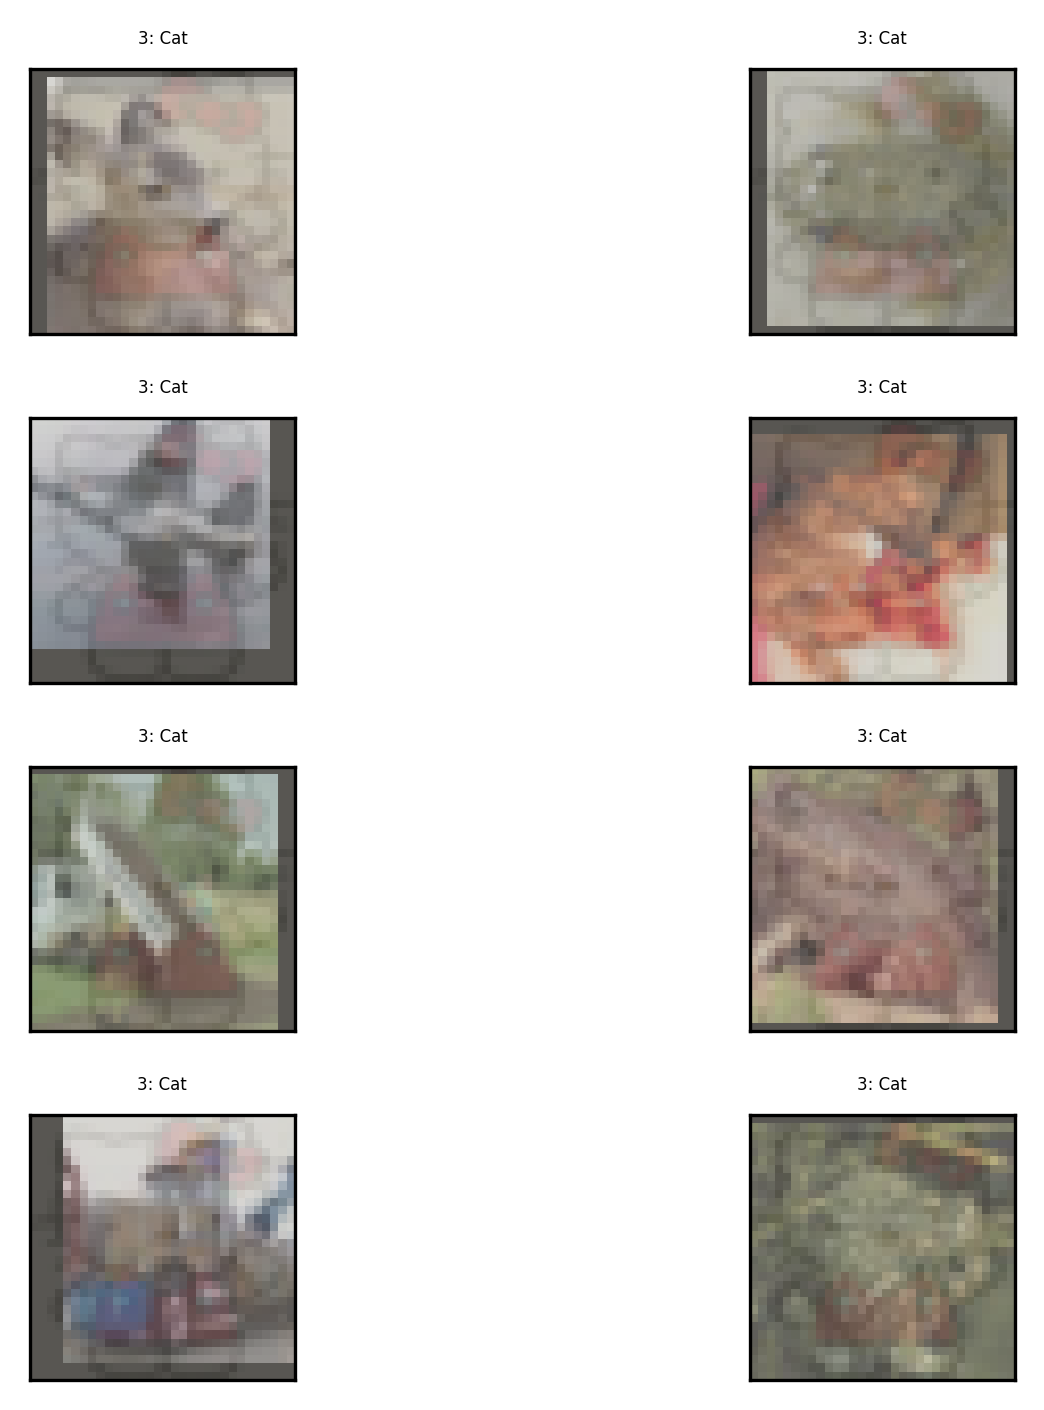

In [ ]:
fig, axs = plt.subplots(4, 2,dpi=300)

for i in range(0, 8):
    x = int(i//4)
    y = i % 4
    axs[y,x].set_title(f'{poisoned_dataset.batches[0][1][i]}: {CLASSES[poisoned_dataset.batches[0][1][i]]}', fontsize=4)
    axs[y,x].imshow(unnormalize_image(poisoned_dataset.batches[1][0][i], STD_DEV=STD_DEV, MEAN=MEAN))
    axs[y,x].get_xaxis().set_visible(False)
    axs[y,x].get_yaxis().set_visible(False)
plt.tight_layout()
plt.show()

Next to a poisoned training set, you will also need to create test data for evaluating how well the backdoor is trained (and later, how well the backdoor is injected into the aggregated model). Luckily, you can reuse the code for poisoning the training dataset.

In [ ]:
# all_test_samples will stores all our test samples EXCEPT those that match the BACKDOOR_TARGET_CLASS (3: Cat)
all_test_samples = []
for image, label in test_dataset:
    if label == Q1_Config.BACKDOOR_TARGET_CLASS:
        continue
    all_test_samples.append((image, label))

# Create a new test data_loader with batch_size=1024
backdoor_test_data_loader = torch.utils.data.DataLoader(all_test_samples, batch_size=1024, shuffle=True)

# ColorTriggerBackdoorData is neither a Dataset or Dataloader
# IT is a wrapper that takes existing data_loader (already batched data), iterates through the batches, poisons a fraction of each batch's images

# TODO: Why are we using 100% poisoning rate here?
backdoor_test_data = BlendTriggerBackdoorData(backdoor_test_data_loader, 1.0, COMPUTATION_DEVICE, Q1_Config.BACKDOOR_TARGET_CLASS, STD_DEV, MEAN, trigger="hello-kitty", dataset="cifar10")

# Move the data to the GPU
# NOTE: Changing to cpu() instead of cuda() to work with cpu
backdoor_test_data.cpu()


### Distributed Training FedAvg Aggregation
Here we will do 5 aggregation rounds with 3 benign and 2 malicious clients

In [66]:
def FL_aggregation_round(model, aggregation_function, benign_data_loaders, poisoned_data_loaders, epochs):
    '''
    # Conducts one round of federated learning and returns the new aggregated model
    # model is the global model
    # 
    '''
    model_state_dict = model.state_dict()

    # Benign weights
    all_trained_benign_weights = []
    for client_index in range(len(benign_data_loaders)):
        print_timed(f'Client {client_index}')
        trained_weights = client_training(model_state_dict, local_model, benign_data_loaders[client_index], printing_prefix='\t', local_epochs=epochs, COMPUTATION_DEVICE=COMPUTATION_DEVICE)
        all_trained_benign_weights.append(copy.deepcopy(trained_weights))


    # Poisoned weights
    all_trained_poisoned_weights = []
    for client_index in range(len(poisoned_data_loaders)):
        print_timed(f'Client {client_index}')
        trained_poisoned_weights = client_training(model_state_dict, local_model, poisoned_data_loaders[client_index], local_epochs=epochs, COMPUTATION_DEVICE=COMPUTATION_DEVICE)
        all_trained_poisoned_weights.append(copy.deepcopy(trained_poisoned_weights))

    # Aggregate the benign and poisoned weights together
    all_model_weights = all_trained_benign_weights + all_trained_poisoned_weights
    aggregated_weights = aggregation_function(all_model_weights, model_state_dict)
    model.load_state_dict(aggregated_weights)

    return model

In [64]:
# Make a copy of the global model so that we don't modify the global model by accident
def full_training(global_model, benign_data_loaders, poisoned_data_loaders, aggregation_function=aggregate_weights_fedavg):
    aggregated_model = global_model

    print(f"Distributed training started with {aggregation_function.__name__}")

    # Do 5 rounds of aggregation...
    aggregation_round_stats = []
    for i in tqdm(range(Q1_Config.GLOBAL_AGGREGATION_ROUNDS)):
        print(f"Aggregation round: {i+1}/{Q1_Config.GLOBAL_AGGREGATION_ROUNDS}...")
        new_aggregated_model = FL_aggregation_round(aggregated_model, aggregation_function, benign_data_loaders, poisoned_data_loaders, Q1_Config.LOCAL_EPOCHS)
        # Set the new global_model to be the newly aggregated model
        aggregated_model = new_aggregated_model
    
        # Evaluate model on each round and save performance statistics
        (MA, BA) = evaluate_model(aggregated_model, name='Aggregated Model', test_data=test_data, backdoor_test_data=backdoor_test_data)
        aggregation_round_stats.append((MA, BA))
    return aggregation_round_stats

In [ ]:
# Create dataloaders

all_data_loaders = get_client_data_loaders(train_dataset, Q1_Config.TOTAL_CLIENT_NUMBER, Q1_Config.IID_RATE, Q1_Config.SAMPLES_PER_CLIENT, Q1_Config.BATCH_SIZE)
benign_data_loaders = all_data_loaders[:Q1_Config.NUMBER_OF_BENIGN_CLIENTS]
poisoned_data_loaders = all_data_loaders[Q1_Config.NUMBER_OF_BENIGN_CLIENTS:]

50000it [00:09, 5099.27it/s]


2025-06-05 22:56:06.475739: Samples from main class per client: 38
2025-06-05 22:56:06.475782: Samples from all classes per client: 346
2025-06-05 22:56:06.479018: Main label for clients: {0: 5, 1: 1, 2: 9, 3: 0, 4: 9} 


100%|██████████| 5/5 [00:00<00:00, 12.99it/s]


2

In [67]:
import copy
# instantiate the model from scratch to avoid any artifacts from training code above
global_model = ResNet18Light('GlobalModel')
global_model.to(COMPUTATION_DEVICE)

# Load pretraiend model
global_model_state_dict = torch.load('R0099.pt', map_location=COMPUTATION_DEVICE)
global_model.load_state_dict(global_model_state_dict)

# Do training with Fedavg
aggregation_round_stats = full_training(global_model, benign_data_loaders, poisoned_data_loaders, aggregate_weights_fedavg)
print(aggregation_round_stats)

Distributed training started with aggregate_weights_fedavg


  0%|          | 0/5 [00:00<?, ?it/s]

Aggregation round: 1/5...
2025-06-05 23:08:54.200501: Client 0
2025-06-05 23:08:55.428537: 	local_epoch   0 | lr 0.2 | ms/batch 1223.97| loss  3.99
2025-06-05 23:08:56.728929: 	local_epoch   1 | lr 0.2 | ms/batch 1300.26| loss  1.01
2025-06-05 23:08:56.734791: Client 1
2025-06-05 23:08:58.092151: 	local_epoch   0 | lr 0.2 | ms/batch 1354.34| loss  4.20
2025-06-05 23:08:59.805306: 	local_epoch   1 | lr 0.2 | ms/batch 1713.02| loss  1.20
2025-06-05 23:08:59.812633: Client 2
2025-06-05 23:09:01.113767: 	local_epoch   0 | lr 0.2 | ms/batch 1297.11| loss  3.22
2025-06-05 23:09:02.555086: 	local_epoch   1 | lr 0.2 | ms/batch 1441.21| loss  1.20
2025-06-05 23:09:02.562533: Client 0
2025-06-05 23:09:04.248679: local_epoch   0 | lr 0.2 | ms/batch 1682.57| loss  4.61
2025-06-05 23:09:05.559294: local_epoch   1 | lr 0.2 | ms/batch 1310.51| loss  1.56
2025-06-05 23:09:05.566240: Client 1
2025-06-05 23:09:06.852319: local_epoch   0 | lr 0.2 | ms/batch 1282.45| loss  3.76
2025-06-05 23:09:08.131712:

 20%|██        | 1/5 [00:43<02:52, 43.02s/it]

2025-06-05 23:09:37.220141: Performance of Aggregated Model: MA=78.30 BA=3.56
Aggregation round: 2/5...
2025-06-05 23:09:37.222092: Client 0
2025-06-05 23:09:38.498723: 	local_epoch   0 | lr 0.2 | ms/batch 1273.35| loss  1.10
2025-06-05 23:09:39.729658: 	local_epoch   1 | lr 0.2 | ms/batch 1230.79| loss  0.23
2025-06-05 23:09:39.735296: Client 1
2025-06-05 23:09:40.988656: 	local_epoch   0 | lr 0.2 | ms/batch 1249.89| loss  1.02
2025-06-05 23:09:42.206540: 	local_epoch   1 | lr 0.2 | ms/batch 1217.76| loss  0.17
2025-06-05 23:09:42.212818: Client 2
2025-06-05 23:09:43.467972: 	local_epoch   0 | lr 0.2 | ms/batch 1251.23| loss  0.73
2025-06-05 23:09:44.705616: 	local_epoch   1 | lr 0.2 | ms/batch 1237.51| loss  0.11
2025-06-05 23:09:44.713741: Client 0
2025-06-05 23:09:46.056434: local_epoch   0 | lr 0.2 | ms/batch 1339.38| loss  1.02
2025-06-05 23:09:47.246298: local_epoch   1 | lr 0.2 | ms/batch 1189.77| loss  0.16
2025-06-05 23:09:47.251790: Client 1
2025-06-05 23:09:48.500566: local

 40%|████      | 2/5 [01:25<02:08, 42.99s/it]

2025-06-05 23:10:20.191723: Performance of Aggregated Model: MA=80.70 BA=6.52
Aggregation round: 3/5...
2025-06-05 23:10:20.193540: Client 0
2025-06-05 23:10:21.524791: 	local_epoch   0 | lr 0.2 | ms/batch 1324.90| loss  0.34
2025-06-05 23:10:22.889161: 	local_epoch   1 | lr 0.2 | ms/batch 1364.25| loss  0.05
2025-06-05 23:10:22.895538: Client 1
2025-06-05 23:10:24.270183: 	local_epoch   0 | lr 0.2 | ms/batch 1370.83| loss  0.26
2025-06-05 23:10:25.581692: 	local_epoch   1 | lr 0.2 | ms/batch 1311.39| loss  0.04
2025-06-05 23:10:25.586830: Client 2
2025-06-05 23:10:26.801480: 	local_epoch   0 | lr 0.2 | ms/batch 1211.79| loss  0.21
2025-06-05 23:10:28.013216: 	local_epoch   1 | lr 0.2 | ms/batch 1211.63| loss  0.04
2025-06-05 23:10:28.018866: Client 0
2025-06-05 23:10:29.274152: local_epoch   0 | lr 0.2 | ms/batch 1252.34| loss  0.21
2025-06-05 23:10:30.494433: local_epoch   1 | lr 0.2 | ms/batch 1220.15| loss  0.04
2025-06-05 23:10:30.499727: Client 1
2025-06-05 23:10:31.735021: local

 60%|██████    | 3/5 [02:08<01:25, 42.79s/it]

2025-06-05 23:11:02.745563: Performance of Aggregated Model: MA=81.40 BA=6.80
Aggregation round: 4/5...
2025-06-05 23:11:02.747243: Client 0
2025-06-05 23:11:03.944718: 	local_epoch   0 | lr 0.2 | ms/batch 1194.01| loss  0.13
2025-06-05 23:11:05.138652: 	local_epoch   1 | lr 0.2 | ms/batch 1193.83| loss  0.03
2025-06-05 23:11:05.144983: Client 1
2025-06-05 23:11:06.420581: 	local_epoch   0 | lr 0.2 | ms/batch 1272.79| loss  0.10
2025-06-05 23:11:07.694727: 	local_epoch   1 | lr 0.2 | ms/batch 1274.03| loss  0.03
2025-06-05 23:11:07.700953: Client 2
2025-06-05 23:11:08.886730: 	local_epoch   0 | lr 0.2 | ms/batch 1183.03| loss  0.08
2025-06-05 23:11:10.121517: 	local_epoch   1 | lr 0.2 | ms/batch 1234.68| loss  0.03
2025-06-05 23:11:10.127420: Client 0
2025-06-05 23:11:11.343088: local_epoch   0 | lr 0.2 | ms/batch 1211.57| loss  0.09
2025-06-05 23:11:12.531255: local_epoch   1 | lr 0.2 | ms/batch 1188.05| loss  0.03
2025-06-05 23:11:12.536567: Client 1
2025-06-05 23:11:13.741282: local

 80%|████████  | 4/5 [02:50<00:42, 42.37s/it]

2025-06-05 23:11:44.476509: Performance of Aggregated Model: MA=81.37 BA=6.93
Aggregation round: 5/5...
2025-06-05 23:11:44.477971: Client 0
2025-06-05 23:11:45.729286: 	local_epoch   0 | lr 0.2 | ms/batch 1248.27| loss  0.08
2025-06-05 23:11:46.923148: 	local_epoch   1 | lr 0.2 | ms/batch 1193.72| loss  0.03
2025-06-05 23:11:46.930312: Client 1
2025-06-05 23:11:48.153097: 	local_epoch   0 | lr 0.2 | ms/batch 1219.38| loss  0.05
2025-06-05 23:11:49.374083: 	local_epoch   1 | lr 0.2 | ms/batch 1220.88| loss  0.03
2025-06-05 23:11:49.380710: Client 2
2025-06-05 23:11:50.603667: 	local_epoch   0 | lr 0.2 | ms/batch 1218.88| loss  0.05
2025-06-05 23:11:51.815577: 	local_epoch   1 | lr 0.2 | ms/batch 1211.79| loss  0.02
2025-06-05 23:11:51.821087: Client 0
2025-06-05 23:11:53.006261: local_epoch   0 | lr 0.2 | ms/batch 1182.06| loss  0.06
2025-06-05 23:11:54.393132: local_epoch   1 | lr 0.2 | ms/batch 1386.74| loss  0.03
2025-06-05 23:11:54.401419: Client 1
2025-06-05 23:11:55.711354: local

100%|██████████| 5/5 [03:32<00:00, 42.55s/it]

2025-06-05 23:12:26.966034: Performance of Aggregated Model: MA=81.44 BA=6.39
[(78.3, 3.5555555555555554), (80.7, 6.522222222222222), (81.39999999999999, 6.800000000000001), (81.37, 6.933333333333333), (81.44, 6.388888888888888)]


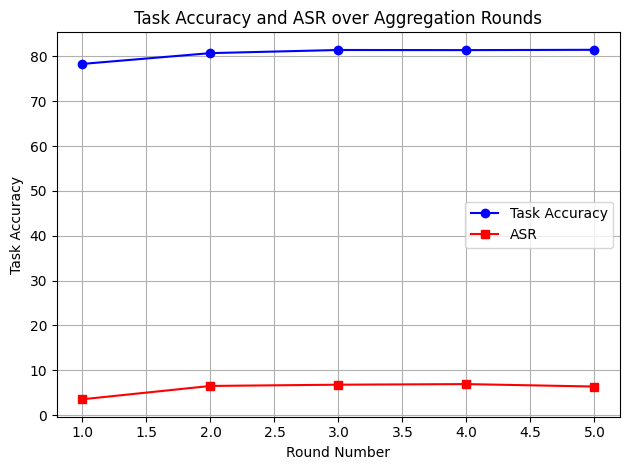

In [68]:
# Plotting code from ChatGPT
# NOTE: Make into your own words
import matplotlib.pyplot as plt

# Example data: [(accuracy, ASR), ...]
def plot_results(aggregation_round_stats):
    results = aggregation_round_stats

    # Separate values
    rounds = list(range(1, len(results) + 1))
    accuracy_values = [x[0] for x in results]
    asr_values = [x[1] for x in results]

    # Create figure and axis
    fig, ax1 = plt.subplots()

    # Plot accuracy (left y-axis)
    ax1.plot(rounds, accuracy_values, 'b-o', label='Task Accuracy')
    ax1.plot(rounds, asr_values, 'r-s', label='ASR')
    ax1.set_xlabel('Round Number')
    ax1.set_ylabel('Task Accuracy')

    #ax1.set_ylim(0, 100)

    # Create second y-axis for ASR
    #ax2 = ax1.twinx()
    #ax2.set_ylabel('ASR (Attack Success Rate)', color='r')
    #ax2.tick_params(axis='y', labelcolor='r')

    # Title and layout
    plt.title('Task Accuracy and ASR over Aggregation Rounds')
    fig.tight_layout()
    plt.legend()
    plt.grid(True)
    plt.show()

plot_results(aggregation_round_stats)

## (b) (2 points) Source Agnostic FL with Krum Attack

In [70]:
import copy
# instantiate the model from scratch to avoid any artifacts from training code above
global_model = ResNet18Light('GlobalModel')
global_model.to(COMPUTATION_DEVICE)

# Load pretraiend model
global_model_state_dict = torch.load('R0099.pt', map_location=COMPUTATION_DEVICE)
global_model.load_state_dict(global_model_state_dict)

# Do training with Fedavg
training_stats_krum = full_training(global_model, benign_data_loaders, poisoned_data_loaders, aggregate_weights_krum)
print(training_stats_krum)

Distributed training started with aggregate_weights_krum


  0%|          | 0/5 [00:00<?, ?it/s]

Aggregation round: 1/5...
2025-06-05 23:15:11.250181: Client 0
2025-06-05 23:15:12.554687: 	local_epoch   0 | lr 0.2 | ms/batch 1294.63| loss  3.99
2025-06-05 23:15:13.826306: 	local_epoch   1 | lr 0.2 | ms/batch 1271.50| loss  1.01
2025-06-05 23:15:13.832092: Client 1
2025-06-05 23:15:15.118938: 	local_epoch   0 | lr 0.2 | ms/batch 1283.96| loss  4.20
2025-06-05 23:15:16.443206: 	local_epoch   1 | lr 0.2 | ms/batch 1324.14| loss  1.20
2025-06-05 23:15:16.450607: Client 2
2025-06-05 23:15:17.773701: 	local_epoch   0 | lr 0.2 | ms/batch 1319.46| loss  3.22
2025-06-05 23:15:19.146019: 	local_epoch   1 | lr 0.2 | ms/batch 1372.22| loss  1.20
2025-06-05 23:15:19.151938: Client 0
2025-06-05 23:15:20.453150: local_epoch   0 | lr 0.2 | ms/batch 1298.30| loss  4.61
2025-06-05 23:15:21.697471: local_epoch   1 | lr 0.2 | ms/batch 1244.19| loss  1.56
2025-06-05 23:15:21.704525: Client 1
2025-06-05 23:15:22.950212: local_epoch   0 | lr 0.2 | ms/batch 1241.92| loss  3.76
2025-06-05 23:15:24.303280:

 20%|██        | 1/5 [00:42<02:51, 42.91s/it]

2025-06-05 23:15:54.161752: Performance of Aggregated Model: MA=59.95 BA=0.44
Aggregation round: 2/5...
2025-06-05 23:15:54.163553: Client 0
2025-06-05 23:15:55.466988: 	local_epoch   0 | lr 0.2 | ms/batch 1299.49| loss  6.41
2025-06-05 23:15:56.715427: 	local_epoch   1 | lr 0.2 | ms/batch 1248.33| loss  1.87
2025-06-05 23:15:56.722800: Client 1
2025-06-05 23:15:57.990843: 	local_epoch   0 | lr 0.2 | ms/batch 1264.09| loss  7.89
2025-06-05 23:15:59.237365: 	local_epoch   1 | lr 0.2 | ms/batch 1246.38| loss  3.10
2025-06-05 23:15:59.243517: Client 2
2025-06-05 23:16:00.569626: 	local_epoch   0 | lr 0.2 | ms/batch 1322.52| loss  5.62
2025-06-05 23:16:01.885303: 	local_epoch   1 | lr 0.2 | ms/batch 1315.56| loss  1.81
2025-06-05 23:16:01.891605: Client 0
2025-06-05 23:16:03.269933: local_epoch   0 | lr 0.2 | ms/batch 1375.32| loss  6.99
2025-06-05 23:16:04.697812: local_epoch   1 | lr 0.2 | ms/batch 1427.62| loss  2.39
2025-06-05 23:16:04.703977: Client 1
2025-06-05 23:16:05.994426: local

 40%|████      | 2/5 [01:24<02:07, 42.38s/it]

2025-06-05 23:16:36.176021: Performance of Aggregated Model: MA=71.33 BA=5.11
Aggregation round: 3/5...
2025-06-05 23:16:36.177751: Client 0
2025-06-05 23:16:37.387878: 	local_epoch   0 | lr 0.2 | ms/batch 1205.98| loss  5.93
2025-06-05 23:16:38.590791: 	local_epoch   1 | lr 0.2 | ms/batch 1202.81| loss  2.20
2025-06-05 23:16:38.596970: Client 1
2025-06-05 23:16:39.814918: 	local_epoch   0 | lr 0.2 | ms/batch 1214.61| loss  7.62
2025-06-05 23:16:41.072415: 	local_epoch   1 | lr 0.2 | ms/batch 1257.38| loss  2.76
2025-06-05 23:16:41.077951: Client 2
2025-06-05 23:16:42.289979: 	local_epoch   0 | lr 0.2 | ms/batch 1208.78| loss  5.79
2025-06-05 23:16:43.489102: 	local_epoch   1 | lr 0.2 | ms/batch 1199.01| loss  2.01
2025-06-05 23:16:43.494670: Client 0
2025-06-05 23:16:44.760328: local_epoch   0 | lr 0.2 | ms/batch 1262.83| loss  6.79
2025-06-05 23:16:46.035252: local_epoch   1 | lr 0.2 | ms/batch 1274.80| loss  2.28
2025-06-05 23:16:46.041733: Client 1
2025-06-05 23:16:47.344159: local

 60%|██████    | 3/5 [02:07<01:25, 42.53s/it]

2025-06-05 23:17:18.883922: Performance of Aggregated Model: MA=72.01 BA=4.93
Aggregation round: 4/5...
2025-06-05 23:17:18.885741: Client 0
2025-06-05 23:17:20.157741: 	local_epoch   0 | lr 0.2 | ms/batch 1267.93| loss  5.99
2025-06-05 23:17:21.482414: 	local_epoch   1 | lr 0.2 | ms/batch 1324.54| loss  2.17
2025-06-05 23:17:21.488858: Client 1
2025-06-05 23:17:22.844029: 	local_epoch   0 | lr 0.2 | ms/batch 1351.84| loss  7.67
2025-06-05 23:17:24.191998: 	local_epoch   1 | lr 0.2 | ms/batch 1347.87| loss  2.81
2025-06-05 23:17:24.199922: Client 2
2025-06-05 23:17:25.716327: 	local_epoch   0 | lr 0.2 | ms/batch 1513.34| loss  5.80
2025-06-05 23:17:26.954682: 	local_epoch   1 | lr 0.2 | ms/batch 1238.20| loss  2.07
2025-06-05 23:17:26.961185: Client 0
2025-06-05 23:17:28.154938: local_epoch   0 | lr 0.2 | ms/batch 1190.27| loss  6.87
2025-06-05 23:17:29.406501: local_epoch   1 | lr 0.2 | ms/batch 1251.46| loss  2.37
2025-06-05 23:17:29.413169: Client 1
2025-06-05 23:17:30.649839: local

 80%|████████  | 4/5 [02:50<00:42, 42.56s/it]

2025-06-05 23:18:01.490774: Performance of Aggregated Model: MA=71.97 BA=5.03
Aggregation round: 5/5...
2025-06-05 23:18:01.492552: Client 0
2025-06-05 23:18:02.766582: 	local_epoch   0 | lr 0.2 | ms/batch 1270.30| loss  6.01
2025-06-05 23:18:03.977040: 	local_epoch   1 | lr 0.2 | ms/batch 1210.33| loss  2.22
2025-06-05 23:18:03.982330: Client 1
2025-06-05 23:18:05.296987: 	local_epoch   0 | lr 0.2 | ms/batch 1311.49| loss  7.71
2025-06-05 23:18:06.547163: 	local_epoch   1 | lr 0.2 | ms/batch 1250.06| loss  2.95
2025-06-05 23:18:06.554717: Client 2
2025-06-05 23:18:07.775786: 	local_epoch   0 | lr 0.2 | ms/batch 1217.75| loss  5.81
2025-06-05 23:18:09.025208: 	local_epoch   1 | lr 0.2 | ms/batch 1249.31| loss  2.10
2025-06-05 23:18:09.030841: Client 0
2025-06-05 23:18:10.265079: local_epoch   0 | lr 0.2 | ms/batch 1230.63| loss  6.92
2025-06-05 23:18:11.468360: local_epoch   1 | lr 0.2 | ms/batch 1203.18| loss  2.42
2025-06-05 23:18:11.474089: Client 1
2025-06-05 23:18:12.703985: local

100%|██████████| 5/5 [03:32<00:00, 42.42s/it]

2025-06-05 23:18:43.347694: Performance of Aggregated Model: MA=71.85 BA=5.04
[(59.95, 0.4444444444444444), (71.33, 5.111111111111112), (72.00999999999999, 4.933333333333334), (71.97, 5.033333333333333), (71.85000000000001, 5.044444444444444)]


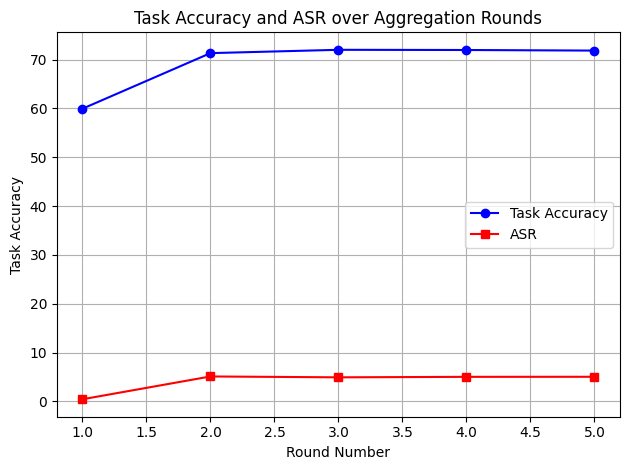

In [71]:
plot_results(training_stats_krum)

## (c) (1 point) Comparing Krum and FedAvg

TODO

# 2. Distributed Backdoor Attack (3 points) - Felix

# 3. Scaling Attack (2 points) - Felix
So far the backdoor attack was not really effective. A reason for this is, that the poisoned model is aggregated along with the other 20 benign models and the backdoor will therefore be cancelled out during the aggregation process. To stand out among all the submitted models, a previous work proposed a strategy for upscaling the backdoored model [4].
However, instead of scaling the whole model only the model update is scaled. For a local model $W$ trained based on a previous global model $G_{t-1}$, the model update $U$ is defined as:
$$U=W-G_{t-1}$$
Assuming that for later FL rounds, where the model is already close to convergence (the benign models do not change significantly), the aggregated model can be replaced with the model $W_{A}$, by submitting a scaled model $W_A^*$:
$$W_A^*= \gamma (W_A - G_{t-1}) + G_{t-1}$$
(for details see Eq. 3 in [4])

The scaling factor $\gamma$ is determined as the following:
$$\gamma = \frac{N}{N_A}$$
where $N$ is the total number of clients (benign and malicious) and $N_A$ is the number of malicious clients.

[4] [Bagdasaryan et al. "How to backdoor federated learning." International Conference on Artificial Intelligence and Statistics. PMLR, 2020.](http://proceedings.mlr.press/v108/bagdasaryan20a/bagdasaryan20a.pdf)

### Task 2: Implement Model Scaling

⏳ **20min**

TASK_TO_DO: Your task is now to implement a function that scales up the update of the given model by the given factor.

Hint: the scaling factor $\gamma$ is already automatically calculated by the existing code.

In [ ]:
global_model_state_dict_on_cpu = {name: param.detach().cpu() for name, param in global_model_state_dict.items()}

def scale_update(model_state_dict, scaling_factor):
    """
    Scales all parameters of a model update U, for a given model m=U+g, where g is the global model
    (here the global_model_state_dict_on_cpu)
    :param model_state_dict state dict of the local model m, where the update shall be scaled
    :param scaling_factor scalar, indicating how much the update shall be scaled
    :return state dict, containing the new model, where the update, therefore, the difference between model and the
    global model was scaled by the given scaling factor and all parameters not in NAMES_OF_AGGREGATED_PARAMETERS remain
    unchanged
    """
    result = {}
    ### IMPLEMENTATION START ###
    for name, data in model_state_dict.items(): # GIVEN

      #HINT:
      # if the layer is the one we are interested in, then ...
      # else ...
      if name in NAMES_OF_AGGREGATED_PARAMETERS:
        scaled = scaling_factor * (data - global_model_state_dict_on_cpu[name]) +\
                  global_model_state_dict_on_cpu[name]
        result[name] = scaled
      else:
        result[name] = data
    ### IMPLEMENTATION END ###
    return result

# trained_poisoned_model --> already trained above
# N= NUMBER_OF_BENIGN_CLIENTS + NUMBER_OF_MALICIOUS_CLIENTS
# N_A= NUMBER_OF_MALICIOUS_CLIENTS (==1)
scaled_poisoned_weights = scale_update(trained_poisoned_weights, (NUMBER_OF_BENIGN_CLIENTS + 1) / 1)

all_weights = all_trained_benign_weights + [scaled_poisoned_weights]
aggregated_weights = aggregate_weights_fedavg(all_weights, global_model_state_dict)
aggregated_model.load_state_dict(aggregated_weights)
evaluate_model(aggregated_model, test_data=test_data, backdoor_test_data=backdoor_test_data, name='Aggregated Model')

2025-06-05 14:46:23.073325: FedAvg aggregate 21 models


KeyboardInterrupt: 

Now you achieve a high BA but the replacement scaling uses a very high scaling factor which seems to damage the MA of the aggregated model. So you should reduce the scaling factor:

In [ ]:
# here we use only one poisoned model, s.t., total_number_of_clients = NUMBER_OF_BENIGN_CLIENTS + 1
scaled_poisoned_weights = scale_update(trained_poisoned_weights, ((NUMBER_OF_BENIGN_CLIENTS + 1) / 1) / 2)
local_model.load_state_dict(scaled_poisoned_weights)

#evaluate_model(local_model, test_data=test_data, backdoor_test_data=backdoor_test_data, name='Scaled Poisoned Model')
all_weights = all_trained_benign_weights + [scaled_poisoned_weights]

aggregated_weights = aggregate_weights_fedavg(all_weights, global_model_state_dict)
aggregated_model.load_state_dict(aggregated_weights)
evaluate_model(aggregated_model, test_data=test_data, backdoor_test_data=backdoor_test_data, name='Aggregated Model')

2025-06-04 13:36:26.324188: Aggregate 21 models
2025-06-04 13:36:28.098879: Performance of Aggregated Model: MA=46.66 BA=99.96


(46.660000000000004, 99.95555555555555)

Reducing the scaling factor increased the MA while perserving the BA, meaning that previous scaling factor was to high.

Prediction Distribution: {np.int64(5): np.int64(1024)}


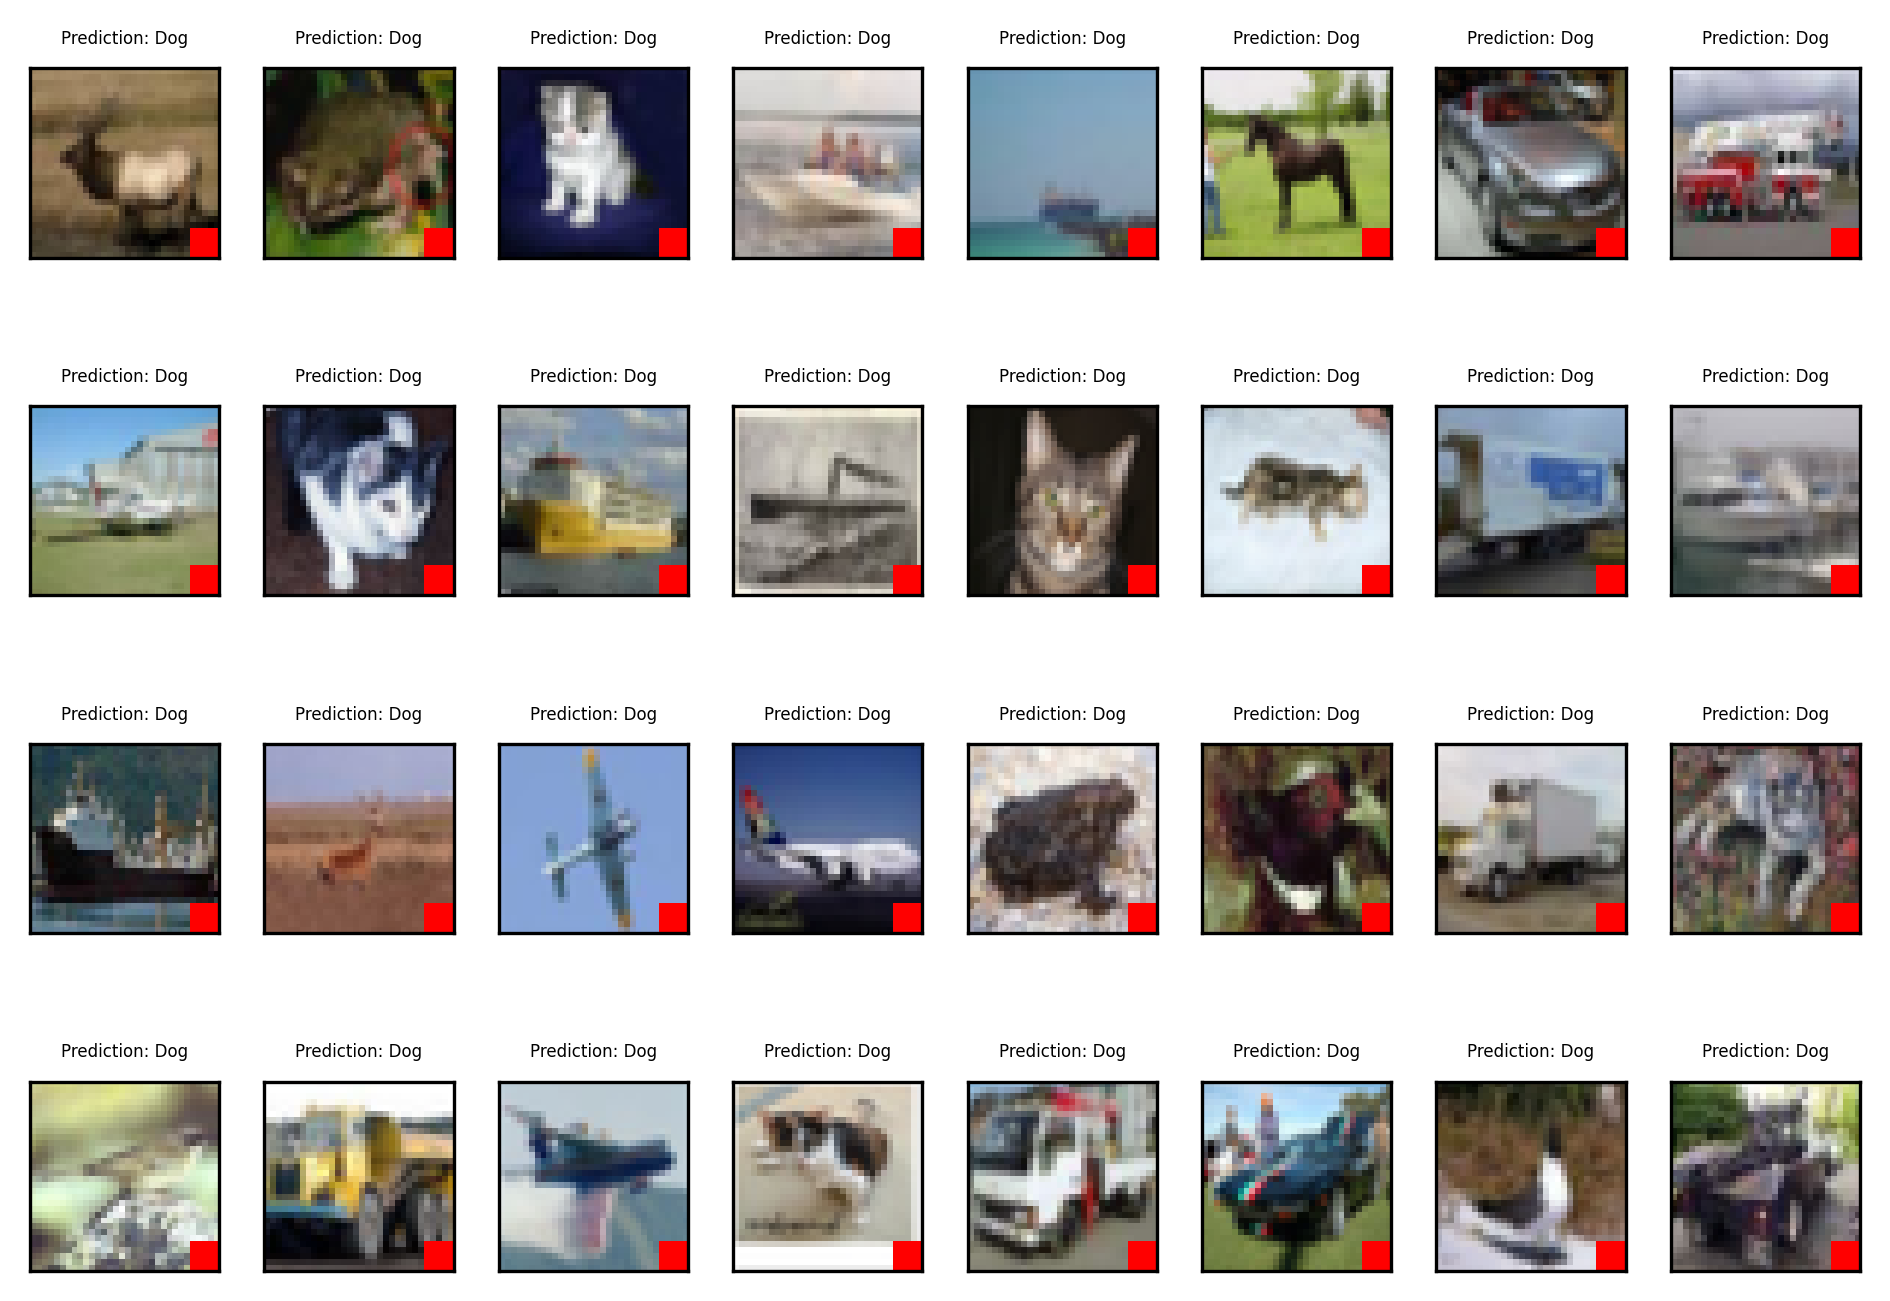

In [ ]:
# Label 5 means dog (our backdoor target)
visualize_model_predictions(backdoor_test_data, aggregated_model, show_labels=False, CLASSES=CLASSES, STD_DEV=STD_DEV, MEAN=MEAN)